# Adapting Student Performance Predictions with Drift Detection and Adaptive BatchNorm

#### Trustworthy AI Examples Series

This notebook explores how temporal changes in academic environments can degrade the performance of student outcome prediction models. Using the Students dataset, it simulates curriculum drift and constructs a resilient prediction pipeline that integrates time-sliced validation, adaptive BatchNorm (AdaBN), and drift-triggered recalibration mechanisms to preserve accuracy over time.

Models trained on historical student cohorts often become obsolete when applied to newer populations due to shifts in course structure, assessment criteria, or learning modalities. These changes disproportionately affect predictions for at-risk students, potentially leading to misallocated academic support or missed scholarship opportunities. To monitor and mitigate this degradation, the notebook tracks performance using metrics such as accuracy, ROC-AUC, and mean predictive entropy.

Through this scenario, readers will:

1. **Understand the real-world stakes**: why curriculum changes disproportionately harm at-risk student predictions.
2. **Learn to construct end-to-end AI pipelines**: from drift detection to sliding window simulation.
3. **Apply robustness strategies in-context**: deploy incremental learning with replay buffers and fading factors.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

from scipy.stats import ks_2samp

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import python.utils.preprocessing as pp

### Set Manual Seed

Setting seeds for random operations allows for reproducible results, which are used within this notebook.

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Data Preparation

In order to train a model on the Students dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

To prepare the dataset for modeling, first transform categorical variables using ordinal encoding, excluding the target to preserve its interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

The `split_data` splits the data for model training and evaluation.

In [4]:
train_data = pp.load_data(PROJECT_ROOT / 'data/students_train.csv')
test_data = pp.load_data(PROJECT_ROOT / 'data/students_test.csv')
df = pd.concat([train_data, test_data], ignore_index=True)
df = pp.handle_missing_values(df, strategy='median')

target_col = 'Target'

df_enc = pp.encode_categorical_data(df, method='ordinal', exclude_cols=[target_col])
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col])

X = df_scaled.drop(columns=[target_col])
y_enc = LabelEncoder().fit_transform(df_scaled[target_col])

X_train, X_test, y_train, y_test = pp.split_data(df_scaled, target_col=target_col, test_size=0.2)

y_train_enc = LabelEncoder().fit_transform(y_train)
y_test_enc = LabelEncoder().fit_transform(y_test)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_test.shape[1] if X_train.shape[1] == X_test.shape[1] else -1}")

Training set size: 3539 samples
Test set size: 885 samples
Number of features: 36


## Simulate Curriculum Drift

The pipeline injects a controlled, feature-specific distribution shift to emulate realistic changes in curriculum and macroeconomic conditions. For each identified drift-sensitive column (those containing `'Curricular_'`, `'Unemployment'`, or `'GDP'`), the function adds a per-row Gaussian shift whose mean is set by the magnitude parameter and whose spread is small (default scale 0.05). This produces a reproducible, noisy upward drift in those variables while leaving other features unchanged. The resulting drifted dataset is used as a test distribution to measure how robust different defenses and adaptation techniques (e.g., CFN, AdaBN, moment-matching) are to realistic, localized non-stationarity in the data.

In [5]:
def simulate_curriculum_drift(X, magnitude=0.2, seed=42):
    np.random.seed(seed)
    X_drifted = X.copy()
    drift_cols = [col for col in X.columns if 'Curricular_' in col or 'Unemployment' in col or 'GDP' in col]
    for col in drift_cols:
        shift = np.random.normal(loc=magnitude, scale=0.05, size=len(X_drifted))
        X_drifted[col] += shift
    return X_drifted

### Drift Visualization

The scatter plot shows original (circles) and drifted (crosses) test examples in a shared two-dimensional PCA projection, making differences in marginal feature distributions visually apparent. A drift magnitude of 0.2 is shown, which corresponds to roughly a 0.2 standard-deviation mean shift in the selected columns. As seen in the visualization, the distribution shifts noticeably but not catastrophically. Most real-world curriculum or economic changes are smaller or evolve gradually, so this magnitude represents a conservative, realistic stress test that can meaningfully affect model performance.

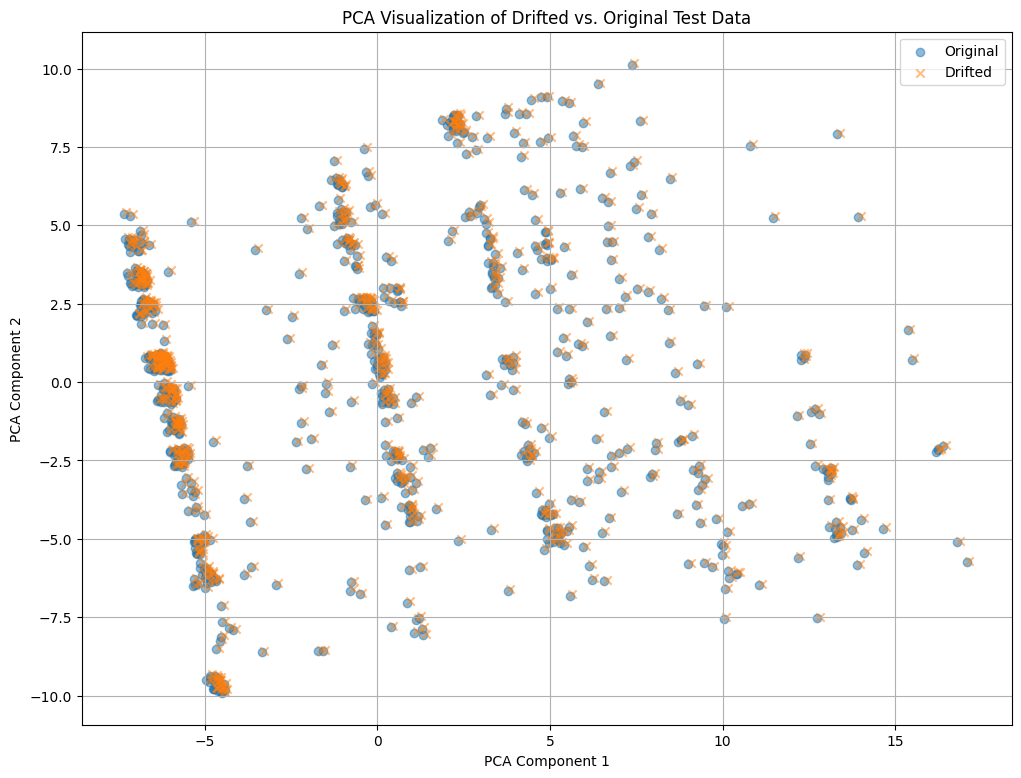

In [6]:
X_test_drifted = simulate_curriculum_drift(X_test)

pca = PCA(n_components=2)
X_combined = np.vstack([X_test, X_test_drifted])
X_pca = pca.fit_transform(X_combined)

n = X_test.shape[0]
X_original_pca = X_pca[:n]
X_drifted_pca = X_pca[n:]

plt.figure(figsize=(12, 9))
plt.scatter(X_original_pca[:, 0], X_original_pca[:, 1], alpha=0.5, label='Original', marker='o')
plt.scatter(X_drifted_pca[:, 0], X_drifted_pca[:, 1], alpha=0.5, label='Drifted', marker='x')
plt.title('PCA Visualization of Drifted vs. Original Test Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

## Drift Detection

The function below applies a Kolmogorov–Smirnov (KS) two-sample test to compare the reference distribution of each feature against its drifted counterpart. For each column, the test statistic and p-value are computed, and features with p-values below the chosen threshold (α = 0.01) are flagged as drifted. This allows the system to automatically identify which variables have undergone significant distributional change, quantifying the extent of simulated drift. In this run, drift was detected in 14 features.

In [7]:
def detect_drift_ks(X_ref, X_new, alpha=0.01):
    drift_results = {}
    for col in X_ref.columns:
        stat, p_value = ks_2samp(X_ref[col], X_new[col])
        drift_results[col] = {"stat": stat, "p_value": p_value, "drift": p_value < alpha}
    return drift_results

drift_results = detect_drift_ks(X_train, X_test_drifted)
drifted_features = [col for col, res in drift_results.items() if res["drift"]]

print(f"Drift detected in {len(drifted_features)} features.")

Drift detected in 14 features.


### Drift Visualization

The following visualization displays KS test results by ranking features according to their drift magnitude (KS statistic) in a horizontal bar plot. Top-ranked curricular features (e.g., `Curricular_NoEval_2nd`, `Curricular_NoEval_1st`) show extremely high KS statistics (>0.9) and near-zero p-values, confirming severe distributional change; in contrast, demographic attributes at the bottom of the ranking (e.g., `Maritalstatus`, `International`, `Nationality`) yield KS statistics close to zero with p-values near 1.0, confirming stability across drifted and reference data. The top 14 features were flagged as potentially drifted, which aligns with the drop-off in KS statistic after the 14th feature (GDP).

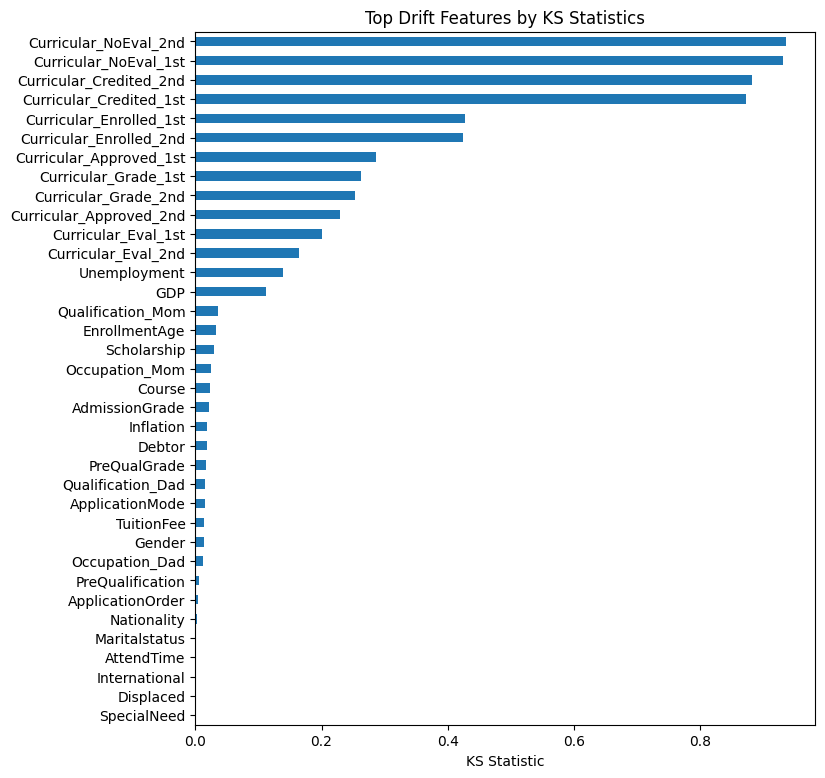

In [8]:
df_res = pd.DataFrame.from_dict(drift_results, orient='index')

df_res = df_res.sort_values('stat', ascending=False)
k = df_res.shape[0]

ax = df_res['stat'].head(k).plot.barh(figsize=(8, max(3, k*0.25)))
ax.invert_yaxis()
plt.title('Top Drift Features by KS Statistics')
plt.xlabel('KS Statistic')
plt.show()

## Multilayer Perceptron Classifier

A simple multilayer perceptron (MLP) is used as a baseline to provide a standard reference point for drift adaptation experiments. It consists of three fully connected layers with hidden dimensions of 64 and 32, each followed by ReLU activations, culminating in an output layer that maps to the target number of classes (3). The model uses Kaiming initialization for weights to promote stable training and sets all biases to zero. Forward propagation simply passes input features sequentially through the defined layers. This compact yet expressive architecture is sufficient to capture patterns in data, but may not be robustness enough to handle curriculum drift.

In [9]:
class BaselineMLP(nn.Module):
    def __init__(self, input_dim, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        return self.net(x)

### Training Function

The training function defines a generic loop used to fit all model architecture in the pipeline, such as the `BaselineMLP` or `DropoutNormMLP`. Input features and labels are first converted into PyTorch tensors and wrapped in a `TensorDataset` and `DataLoader` for efficient mini-batch training. The optimizer is `Adam`, optionally combined with weight decay for regularization, while the loss is computed using cross-entropy, suitable for multi-class classification tasks. A learning rate scheduler (`ReduceLROnPlateau`) is applied, reducing the step size if training loss stagnates, which helps improve convergence stability. The loop iterates over a fixed number of epochs, computing gradients, backpropagating errors, and updating model parameters, ultimately returning the fully trained model for downstream evaluation under drift.

In [10]:
def train_model(model, X_train, y_train, epochs=100, batch_size=64, lr=1e-3, weight_decay=0.0, use_scheduler=True):
    model.train()

    X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5) if use_scheduler else None

    for _ in range(epochs):
        epoch_loss = 0.0
        for X, y in dataloader:
            optimizer.zero_grad()
            outputs = model(X)
            if isinstance(outputs, tuple): outputs = outputs[0]
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if scheduler:
            scheduler.step(epoch_loss / len(dataloader))

    return model

baseline_model = train_model(BaselineMLP(X_train.shape[1]), X_train, y_train_enc)

### Model Evaluation

The evaluation stage measures model performance on a held-out test set using multiple complementary metrics. The function first computes predicted class probabilities via a softmax transformation and then derives the most likely label for each test example. Accuracy captures overall classification correctness, while the multi-class ROC AUC score evaluates the model’s ability to rank true labels higher than false ones across all classes. In addition, predictive entropy is calculated as an uncertainty measure, quantifying the confidence distribution of the model’s predictions. Together, these metrics aim to provide a holistic view of both performance and calibration under drifted conditions.

For the baseline model, evaluation on the drifted test data yields an accuracy of 0.771 and a ROC AUC score of 0.849, indicating reasonably strong performance despite distributional shift. The mean predictive entropy of 0.326 suggests that the model maintains moderate confidence in its predictions, with some degree of uncertainty introduced by the drift. While the model does not completely collapse under distributional change, the gap between accuracy and AUC implies that errors are concentrated in specific classes rather than uniformly distributed. This reinforces the need to explore further methods, which may help the model retain high performance under non-stationarity.

In [11]:
def predictive_entropy(probs, eps=1e-10):
    probs = np.clip(probs, eps, 1 - eps)
    return -np.sum(probs * np.log(probs), axis=1)

def evaluate_model(model, X_test, y_test):
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    model.eval()
    with torch.no_grad():
        try:
            logits = model(X_test_tensor)
        except:
            logits, _ = model(X_test_tensor, lambda_=0.0)
        y_pred_probs = torch.softmax(logits, dim=1).numpy()
        y_pred_labels = np.argmax(y_pred_probs, axis=1)
    
    y_true = y_test_tensor.numpy()

    acc = accuracy_score(y_true, y_pred_labels)
    auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
    ent = predictive_entropy(y_pred_probs)

    return acc, auc, ent

acc, auc, ent = evaluate_model(baseline_model, X_test_drifted, y_test_enc)

print("=== Baseline Model ===")
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC Score: {auc:.3f}")
print(f"Mean Predictive Entropy: {ent.mean():.3f}")

=== Baseline Model ===
Accuracy: 0.771
ROC AUC Score: 0.849
Mean Predictive Entropy: 0.326


## Clustered Feature Noise

Clustered feature noise (CFN) is a technique that introduces structured noise into the training dataset to improve robustness and simulate real-world feature perturbations. Instead of injecting noise uniformly across all features, the function first standardizes the feature matrix and applies KMeans clustering to group features with similar distributions. Each cluster is assigned an importance score based on the average variance of its features, with higher-variance clusters considered more stable and thus receiving less noise. For each cluster, Gaussian noise is added to its features in proportion to their stability, ensuring that weaker clusters experience greater perturbation. The result is a modified training dataset where noise injection is guided by feature structure, which helps the model to generalize beyond fragile patterns that may be broken by distributional shift.

In [12]:
def clustered_feature_noise(X, noise_level=0.1, n_clusters=5, random_state=42):
    """Add feature-wise noise based on clustering of features."""
    X_df = X.copy()
    scaler = StandardScaler()
    X_t = scaler.fit_transform(X_df.T)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    feat_clusters = kmeans.fit_predict(X_t)
    cluster_importance = np.zeros(n_clusters)

    for k in range(n_clusters):
        cols = np.where(feat_clusters == k)[0]
        if len(cols):
            cluster_importance[k] = X_df.iloc[:, cols].var(axis=0).mean()
    
    if cluster_importance.max() > 0:
        cluster_importance /= cluster_importance.max()
    
    X_noisy = X_df.copy()
    for k in range(n_clusters):
        cols = np.where(feat_clusters == k)[0]
        level = noise_level * (1.0 - cluster_importance[k])
        for col_idx in cols:
            std = X_df.iloc[:, col_idx].std()
            if std > 0:
                rng = np.random.RandomState(42 + k + col_idx)
                noise = rng.normal(0, level * std, size=len(X_df))
                X_noisy.iloc[:, col_idx] += noise
                
    return X_noisy

X_train_noisy = clustered_feature_noise(X_train, noise_level=0.1, n_clusters=5)
noisy_model = train_model(BaselineMLP(X_train.shape[1]), X_train_noisy, y_train_enc)

### Model Evaluation

The CFN model demonstrates modest but meaningful improvements over the baseline in handling drifted data. Its accuracy raised slightly from 0.771 to 0.774, while the ROC AUC showed a larger gain from 0.849 to 0.863, indicating that CFN enhances the model’s ability to distinguish between classes under distributional shift. At the same time, the mean predictive entropy decreases from 0.326 to 0.311, suggesting that the CFN-trained model produces more confident predictions. While CFN made important improvements, further work must be done to ensure the model is safe for deployment.

In [13]:
acc_cfn, auc_cfn, ent_cfn = evaluate_model(noisy_model, X_test_drifted, y_test_enc)

print("=== Clustered Feature Noise Model ===")
print(f"Accuracy: {acc_cfn:.3f}")
print(f"ROC AUC Score: {auc_cfn:.3f}")
print(f"Mean Predictive Entropy: {ent_cfn.mean():.3f}")

=== Clustered Feature Noise Model ===
Accuracy: 0.774
ROC AUC Score: 0.863
Mean Predictive Entropy: 0.311


## Dropout Normalization Model

The Dropout Normalization Model (`DropoutNormMLP`) extends the baseline MLP by incorporating both Batch Normalization and Dropout, two widely used techniques to improve generalization and robustness. The network begins with a larger hidden layer of 128 neurons, followed by batch normalization, ReLU activation, and a dropout layer with a relatively high rate (0.4) to prevent overfitting. This is followed by progressively smaller hidden layers (64 and 32 units), each with batch normalization and dropout (0.3 in the second stage), before reaching the final classification layer. Similar to the baseline, the architecture is initialized with Kaiming-normal weights for stable training of ReLU-based networks and zero biases to reduce initial bias in activations.

In [14]:
class DropoutNormMLP(nn.Module):
    """A multilayer perceptron with BatchNorm + Dropout architecture."""
    def __init__(self, input_dim, num_classes=3, drates=(0.4,0.3)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(drates[0]),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(drates[1]),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
    
    def forward(self, x):
        return self.net(x)

dropout_model = train_model(DropoutNormMLP(X_train.shape[1]), X_train_noisy, y_train_enc)

### Model Evaluation

The Dropout Normalization Model demonstrates a clear improvement over both the baseline and CFN models. Its accuracy increased to 0.786, surpassing the CFN model’s 0.774 and the baseline’s 0.771, indicating better generalization to the drifted test data. The ROC AUC score rose sharply to 0.900, reflecting more confident predictions across all classes compared to the CFN model baseline. However, the mean predictive entropy also increased to 0.490, suggesting that while the model is more confident in its predictions, it maintains some uncertainty. This can be advantageous for downstream adaptation techniques in moderate amounts, but could pose a problem should it increase with future techniques.

In [15]:
acc_drp, auc_drp, ent_drp = evaluate_model(dropout_model, X_test_drifted, y_test_enc)

print("=== Dropout Normalization Model ===")
print(f"Accuracy: {acc_drp:.3f}")
print(f"ROC AUC Score: {auc_drp:.3f}")
print(f"Mean Predictive Entropy: {ent_drp.mean():.3f}")

=== Dropout Normalization Model ===
Accuracy: 0.786
ROC AUC Score: 0.900
Mean Predictive Entropy: 0.490


## Adaptive BatchNorm

The Adaptive BatchNorm (AdaBN) technique recalibrates the batch normalization statistics of a pre-trained neural network using unlabeled adaptation data. The function first sets the model to training mode and temporarily disables the momentum of all batch normalization layers to ensure that the running mean and variance are recomputed directly from the adaptation data. It then iterates over the adaptation dataset, passing each batch through the network without updating any weights, so that only the batch normalization statistics are updated. After processing the adaptation data, the original momenta are restored and the model is returned to evaluation mode. This approach allows the model to adjust to shifts in feature distributions, thereby improving drift robustness without requiring additional labeled data.

In [16]:
def adapt_batchnorm(model, adaptation_loader):
    """Recompute BatchNorm running stats using unlabeled adaptation data."""
    model.train()

    backup_momenta = {}
    for m in model.modules():
        if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
            backup_momenta[m] = m.momentum
            m.momentum = None

    with torch.no_grad():
        for batch in adaptation_loader:
            if isinstance(batch, (list, tuple)):
                x = batch[0]
            else:
                x = batch
            _ = model(x)

    for m, mom in backup_momenta.items():
        m.momentum = mom

    model.eval()
    return model

## 

### Evaluation Split

In order to use AdaBN, the dataset is partitioned into two distinct subsets: an adaptation set used to recalibrate model statistics, and an evaluation set used to assess performance. The `split_adaptation_eval_indices` function generates a reproducible random permutation of all sample indices and selects the first fraction, defined by `adapt_frac`, as the adaptation indices, with the remainder reserved for evaluation. In the main body, the adaptation indices are converted into a `DataLoader` to feed into the function for AdaBN recalibration, while the evaluation indices are used to create `X_eval_drifted` and `y_eval` for performance assessment. This ensures that the model can be accessed reliably by avoiding any test label leakage.

In [17]:
def split_adaptation_eval_indices(n_samples, adapt_frac=0.2, seed=42):
    rng = np.random.RandomState(seed)
    idx = rng.permutation(n_samples)
    split = int(np.floor(adapt_frac * n_samples))
    
    adapt_idx = idx[:split]
    eval_idx  = idx[split:]

    return adapt_idx, eval_idx

adapt_idx, eval_idx = split_adaptation_eval_indices(len(X_test_drifted), adapt_frac=0.2, seed=42)

X_eval_drifted = X_test_drifted.iloc[eval_idx]
y_eval = y_test_enc[eval_idx]

X_adapt_tensor = torch.tensor(X_test_drifted.values[adapt_idx], dtype=torch.float32)
y_adapt_tensor = torch.zeros(len(adapt_idx), dtype=torch.long)
adapt_dataset = TensorDataset(X_adapt_tensor, y_adapt_tensor)
adapt_loader = DataLoader(adapt_dataset, batch_size=64, shuffle=True)

adabn_model = adapt_batchnorm(dropout_model, adapt_loader)

### Model Evaluation

The AdaBN model demonstrates improved alignment with the drifted evaluation data compared to previous models. With an accuracy of 0.792 and ROC AUC of 0.903, it slightly outperformed the Dropout Normalization model (0.786 accuracy, 0.900 AUC). The mean predictive entropy remained the same from the Dropout Normalization model (0.490), indicating similar confidence in predictions. Overall, this step illustrates that recalibrating batch normalization statistics using unlabeled adaptation data better mitigates robustness issues from a shifted data distribution.

In [18]:
acc_ada, auc_ada, ent_ada = evaluate_model(adabn_model, X_eval_drifted, y_eval)

print("=== Adaptive BatchNorm Model ===")
print(f"Accuracy: {acc_ada:.3f}")
print(f"ROC AUC Score: {auc_ada:.3f}")
print(f"Mean Predictive Entropy: {ent_ada.mean():.3f}")

=== Adaptive BatchNorm Model ===
Accuracy: 0.792
ROC AUC Score: 0.903
Mean Predictive Entropy: 0.490


## Moment Matching

Moment matching is a feature-wise normalization technique that aligns the statistical distribution of data being predicted on with that of the original training data. The `fit_moment_match` function calculates the mean and standard deviation for each feature in both the source (training) and target (evaluation) datasets, adding a small epsilon to prevent division by zero. The `apply_moment_match` function then rescales and shifts each feature of the target dataset so that its distribution matches the moments of the source dataset.

This transformation is particularly useful when distribution drift has altered the location or scale of features, as it allows models trained on the original distribution to perform more reliably. By applying this correction to `X_eval_drifted`, the pipeline creates a normalized evaluation set (`X_eval_moment`) that is better aligned with the model’s learned feature space.

In [19]:
def fit_moment_match(source_df, target_df, eps=1e-6):
    mu_s = source_df.mean(0).values; mu_t = target_df.mean(0).values
    std_s = source_df.std(0).values + eps; std_t = target_df.std(0).values + eps
    return {"mu_s": mu_s, "mu_t": mu_t, "std_s": std_s, "std_t": std_t}

def apply_moment_match(X_df, params):
    mu_s, mu_t, std_s, std_t = params["mu_s"], params["mu_t"], params["std_s"], params["std_t"]
    X = X_df.values
    X_mm = (X - mu_t) / std_t * std_s + mu_s
    return pd.DataFrame(X_mm, columns=X_df.columns, index=X_df.index)

moment_match_params = fit_moment_match(X_train_noisy, X_eval_drifted)
X_eval_moment = apply_moment_match(X_eval_drifted, moment_match_params)

### Model Evaluation

Combining moment matching with the previous AdaBN model showed that accuracy remained at 0.792, consistent with the AdaBN-only model, while the ROC AUC improved slightly to 0.905, indicating better class separation under drifted conditions. Predictive entropy also increased to 0.500, reflecting a moderate increase in uncertainty. Compared with prior models, this combination maintains strong accuracy and AUC, although the predictive entropy is cause for concern. Fortunately, this disparity can be addressed with confidence sharpening.

In [20]:
acc_mom, auc_mom, ent_mom = evaluate_model(adabn_model, X_eval_moment, y_eval)

print("=== Moment Matching + AdaBN Model ===")
print(f"Accuracy: {acc_mom:.3f}")
print(f"ROC AUC Score: {auc_mom:.3f}")
print(f"Mean Predictive Entropy: {ent_mom.mean():.3f}")

=== Moment Matching + AdaBN Model ===
Accuracy: 0.792
ROC AUC Score: 0.905
Mean Predictive Entropy: 0.500


## Confidence Sharpening

Confidence sharpening is a simple, interpretable output-level adjustment that makes probabilistic predictions more decisive without retraining. The `sharpen_predictions` transform raises probabilities to a power (`gamma>1`) and renormalizes, which moves values away from 0.5 toward 0 or 1.

In [21]:
def sharpen_predictions(probs, gamma=1.5, eps=1e-10):
    probs = np.clip(probs, eps, 1 - eps)
    sharp = probs**gamma / (probs**gamma).sum(axis=1, keepdims=True)
    
    return sharp

### Generating Sharpened Probabilities

In order to apply confidence sharpening the model’s output probabilities are first obtained for the evaluation data. These probabilities represent the model’s raw confidence across all classes for each sample. The `sharpen_predictions` function is then applied to increase the decisiveness of these predictions by amplifying higher probabilities and suppressing lower ones, effectively pushing them closer to 0 or 1.

This transformation is purely post-hoc and does not require retraining. The resulting sharpened probabilities are then ready for subsequent evaluation or metric calculation.

In [22]:
def get_probs(model, X):
    model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs

probs_eval = get_probs(adabn_model, X_eval_moment)

probs_sharp = sharpen_predictions(probs_eval)
y_pred_labels_sharp = probs_sharp.argmax(axis=1)

### Model Evaluation

The AdaBN model is combined with moment matching and confidence sharpening to produce final predictions. Accuracy and ROC AUC remained consistent with the previous model (moment matching + AdaBN), indicating that the sharpening step did not alter classification correctness or overall ranking performance. However, mean predictive entropy decreased substantially from 0.500 to 0.332, showing that the model’s probabilistic outputs have become more decisive. Overall, confidence sharpening improved interpretability and decisiveness while maintaining prior performance gains.

In [23]:
acc_shp = accuracy_score(y_eval, y_pred_labels_sharp)
auc_shp = roc_auc_score(y_eval, probs_sharp, multi_class='ovr')
ent_shp = predictive_entropy(probs_sharp)

print("=== Confidence-Sharpened Moment Matching + AdaBN Model ===")
print(f"Accuracy: {acc_shp:.3f}")
print(f"ROC AUC Score: {auc_shp:.3f}")
print(f"Mean Predictive Entropy: {ent_shp.mean():.3f}")

=== Confidence-Sharpened Moment Matching + AdaBN Model ===
Accuracy: 0.792
ROC AUC Score: 0.905
Mean Predictive Entropy: 0.332


## Model Comparison

### Accuracy Plot

The accuracy comparison plot illustrates a clear upward trend in classification performance across successive models. Starting from the baseline model at 0.771, the addition of Clustered Feature Noise (CFN) provides a small improvement to 0.774, reflecting modest robustness gains. Incorporating Dropout and BatchNorm further increases accuracy to 0.786, while Adaptive BatchNorm (AdaBN) elevates it to 0.792, indicating effective adaptation to drifted data. Moment matching maintains this peak accuracy, showing that aligning feature distributions does not harm predictive correctness. Finally, confidence sharpening preserves accuracy at 0.792, demonstrating that output-level adjustments improve interpretability without sacrificing performance.

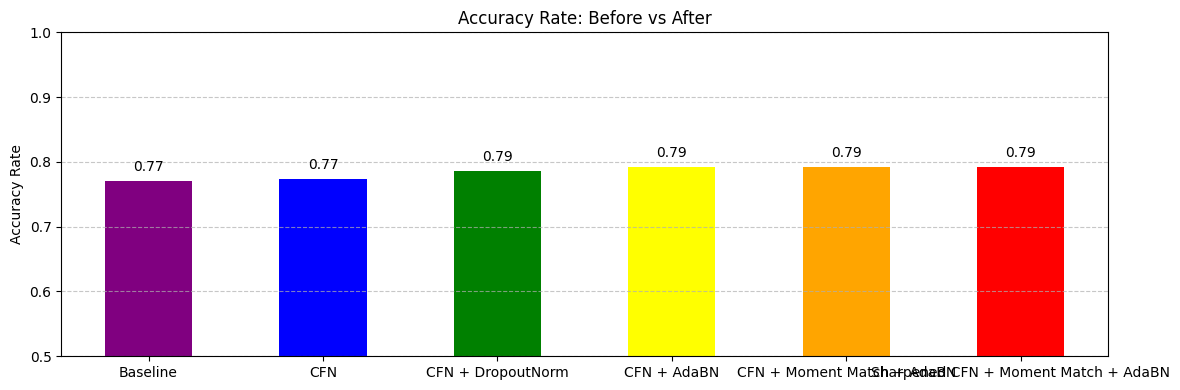

In [24]:
accuracy_comparison = pd.DataFrame({
    'Accuracy Rate': [acc, acc_cfn, acc_drp, acc_ada, acc_mom, acc_shp]
}, index=['Baseline',
          'CFN',
          'CFN + DropoutNorm',
          'CFN + AdaBN',
          'CFN + Moment Match + AdaBN',
          'Sharpened CFN + Moment Match + AdaBN'])

colors = ['purple', 'blue', 'green', 'yellow', 'orange', 'red']
accuracy_series = accuracy_comparison['Accuracy Rate']

ax = accuracy_series.plot(kind='bar', figsize=(12, 4), color=colors)
plt.ylabel('Accuracy Rate'); plt.title('Accuracy Rate: Before vs After'); plt.ylim(0.5, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(accuracy_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### ROC AUC Plot

The ROC AUC plot shows a similar pattern of progressive improvement in discriminative ability. The baseline model starts at 0.849, and CFN boosts it to 0.863, showing enhanced separation between classes under noisy features. Dropout and BatchNorm further raises AUC to 0.900, with AdaBN slightly improving it to 0.903. Moment matching provides a marginal increase to 0.905, indicating better calibration of probabilities relative to the training distribution. Confidence sharpening preserves the ROC AUC at 0.905, confirming that sharpening does not alter class ranking while increasing decisiveness in predictions.

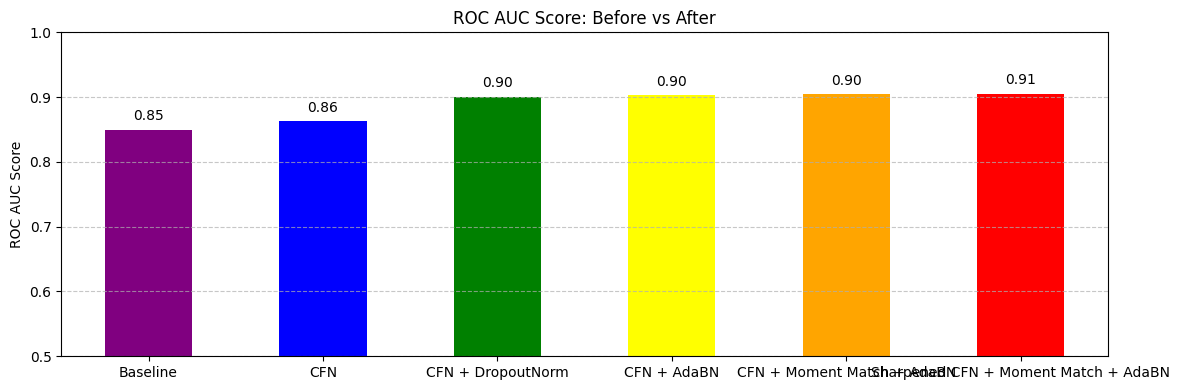

In [25]:
roc_auc_comparison = pd.DataFrame({
    'ROC AUC Score': [auc, auc_cfn, auc_drp, auc_ada, auc_mom, auc_shp]
}, index=['Baseline',
          'CFN',
          'CFN + DropoutNorm',
          'CFN + AdaBN',
          'CFN + Moment Match + AdaBN',
          'Sharpened CFN + Moment Match + AdaBN'])

colors = ['purple', 'blue', 'green', 'yellow', 'orange', 'red']
roc_auc_series = roc_auc_comparison['ROC AUC Score']

ax = roc_auc_series.plot(kind='bar', figsize=(12, 4), color=colors)
plt.ylabel('ROC AUC Score'); plt.title('ROC AUC Score: Before vs After'); plt.ylim(0.5, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(roc_auc_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### Mean Predictive Entropy Plot

The mean predictive entropy plot highlights changes in predictive uncertainty across models. The baseline model exhibits moderate uncertainty at 0.326, which slightly decreases for CFN (0.311) but rises substantially when Dropout and BatchNorm is added (0.490), reflecting regularization-induced output variability. AdaBN maintains high entropy (0.490), consistent with model adaptation under drift. Moment matching increases entropy slightly to 0.500, reflecting a more balanced probability distribution after feature alignment. Finally, confidence sharpening dramatically reduces entropy to 0.332, indicating more decisive predictions while maintaining prior gains in accuracy and AUC.

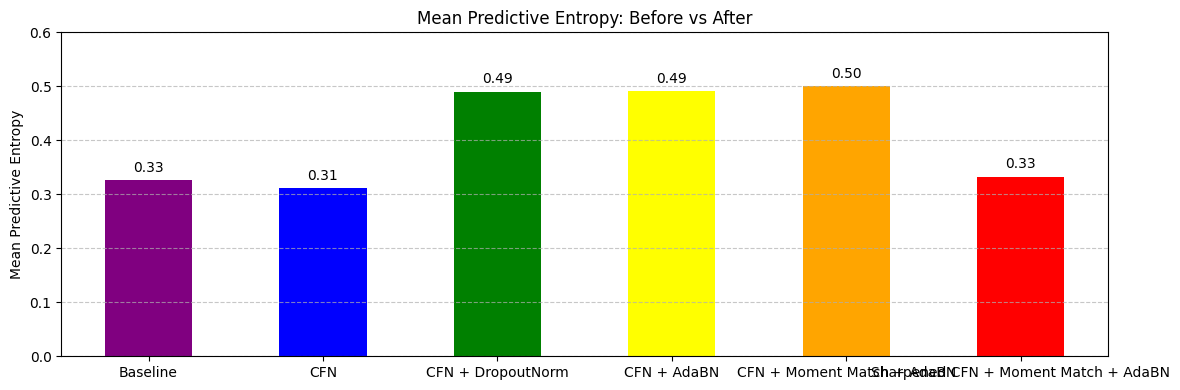

In [26]:
entropy_comparison = pd.DataFrame({
    'Mean Predictive Entropy': [ent.mean(), ent_cfn.mean(), ent_drp.mean(), ent_ada.mean(), ent_mom.mean(), ent_shp.mean()]
}, index=['Baseline',
          'CFN',
          'CFN + DropoutNorm',
          'CFN + AdaBN',
          'CFN + Moment Match + AdaBN',
          'Sharpened CFN + Moment Match + AdaBN'])

colors = ['purple', 'blue', 'green', 'yellow', 'orange', 'red']
entropy_series = entropy_comparison['Mean Predictive Entropy']

ax = entropy_series.plot(kind='bar', figsize=(12, 4), color=colors)
plt.ylabel('Mean Predictive Entropy'); plt.title('Mean Predictive Entropy: Before vs After'); plt.ylim(0, 0.6); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(entropy_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

## Sliding Window Simulation

The sliding window simulation function provides a dynamic evaluation of model performance over time, particularly under conditions of distributional drift. It sequentially applies the adaptation strategies explored in this pipeline (CFN, dropout + BatchNorm, AdaBN, moment matching, confidence sharpening) across multiple windows of test data. At the designated drift window, the function simulates a curriculum drift to evaluate how each model adapts in real time. This simulation will demonstrate the comparative robustness and adaptability of the models when faced with evolving data distributions.

In [27]:
def sliding_window_simulation(
        X_train, y_train,
        X_test, y_test,
        n_windows=8,
        drift_start=3,
        drift_mag=0.5,
        adapt_frac=0.2,
        noise_level=0.1,
        n_clusters=5,
        epochs=50,
        drift_alpha=0.05):
    """
    Windowed simulation for:
      1. Baseline
      2. Clustered Feature Noise + Baseline
      3. Clustered Feature Noise + DropoutNormMLP
      4. CFN + DropoutNormMLP + AdaBN
      5. CFN + DropoutNormMLP + AdaBN + Moment Matching
      6. CFN + DropoutNormMLP + AdaBN + Moment Matching + Sharpening
    """
    X_window = X_test

    names = ['baseline', 'cfn', 'dropout', 'adabn', 'moment', 'sharpened']
    histories = {name: {'acc': [], 'auc': [], 'ent': []} for name in names}
    histories['drift_ratio'] = []
    
    baseline_model = train_model(BaselineMLP(X_train.shape[1]), X_train, y_train, epochs=epochs)
    X_train_noisy = clustered_feature_noise(X_train, noise_level=noise_level, n_clusters=n_clusters)
    cfn_model = train_model(BaselineMLP(X_train.shape[1]), X_train_noisy, y_train, epochs=epochs)
    dropout_model = train_model(DropoutNormMLP(X_train.shape[1]), X_train_noisy, y_train, epochs=epochs)

    adapt_idx, eval_idx = split_adaptation_eval_indices(len(X_window), adapt_frac=adapt_frac, seed=42)
    X_adapt_tensor = torch.tensor(X_window.values[adapt_idx], dtype=torch.float32)
    y_adapt_tensor = torch.zeros(len(adapt_idx), dtype=torch.long)
    adapt_dataset = TensorDataset(X_adapt_tensor, y_adapt_tensor)
    adapt_loader = DataLoader(adapt_dataset, batch_size=64, shuffle=True)

    adabn_model = adapt_batchnorm(dropout_model, adapt_loader)

    X_eval = X_window.iloc[eval_idx]
    y_eval = y_test_enc[eval_idx]

    moment_match_params = fit_moment_match(X_train_noisy, X_eval)
    X_eval_moment = apply_moment_match(X_eval, moment_match_params)

    probs_eval = get_probs(adabn_model, X_eval_moment)

    probs_sharp = sharpen_predictions(probs_eval)
    y_pred_labels_sharp = probs_sharp.argmax(axis=1)

    for w in range(n_windows):
        if w == drift_start:
            X_window = simulate_curriculum_drift(X_test, magnitude=drift_mag, seed=42)
        elif w == drift_start + 1:
            baseline_model = train_model(BaselineMLP(X_train.shape[1]), X_train, y_train, epochs=epochs)
            X_train_noisy = clustered_feature_noise(X_train, noise_level=noise_level, n_clusters=n_clusters)
            cfn_model = train_model(BaselineMLP(X_train.shape[1]), X_train_noisy, y_train, epochs=epochs)
            dropout_model = train_model(DropoutNormMLP(X_train.shape[1]), X_train_noisy, y_train, epochs=epochs)
        elif w > drift_start + 1:
            baseline_model = train_model(baseline_model, X_train, y_train, epochs=10)
            cfn_model = train_model(cfn_model, X_train_noisy, y_train, epochs=10)
            dropout_model = train_model(dropout_model, X_train_noisy, y_train, epochs=10)

        adapt_idx, eval_idx = split_adaptation_eval_indices(len(X_window), adapt_frac=0.2, seed=42)
        X_adapt_tensor = torch.tensor(X_window.values[adapt_idx], dtype=torch.float32)
        y_adapt_tensor = torch.zeros(len(adapt_idx), dtype=torch.long)
        adapt_dataset = TensorDataset(X_adapt_tensor, y_adapt_tensor)
        adapt_loader = DataLoader(adapt_dataset, batch_size=64, shuffle=True)

        adabn_model = adapt_batchnorm(dropout_model, adapt_loader)

        X_eval = X_window.iloc[eval_idx]
        y_eval = y_test_enc[eval_idx]

        moment_match_params = fit_moment_match(X_train_noisy, X_eval)
        X_eval_moment = apply_moment_match(X_eval, moment_match_params)

        probs_eval = get_probs(adabn_model, X_eval_moment)

        probs_sharp = sharpen_predictions(probs_eval)
        y_pred_labels_sharp = probs_sharp.argmax(axis=1)

        drift_results = detect_drift_ks(X_test, X_window, alpha=drift_alpha)
        drifted_features = [f for f, r in drift_results.items() if r['drift']]
        drift_ratio = len(drifted_features) / float(X_window.shape[1])
        histories['drift_ratio'].append(drift_ratio)

        acc, auc, ent = evaluate_model(baseline_model, X_window, y_test)
        histories['baseline']['acc'].append(acc)
        histories['baseline']['auc'].append(auc)
        histories['baseline']['ent'].append(ent.mean())

        acc_cfn, auc_cfn, ent_cfn = evaluate_model(cfn_model, X_window, y_test)
        histories['cfn']['acc'].append(acc_cfn)
        histories['cfn']['auc'].append(auc_cfn)
        histories['cfn']['ent'].append(ent_cfn.mean())

        acc_drp, auc_drp, ent_drp = evaluate_model(dropout_model, X_window, y_test)
        histories['dropout']['acc'].append(acc_drp)
        histories['dropout']['auc'].append(auc_drp)
        histories['dropout']['ent'].append(ent_drp.mean())

        acc_ada, auc_ada, ent_ada = evaluate_model(dropout_model, X_eval, y_eval)
        histories['adabn']['acc'].append(acc_ada)
        histories['adabn']['auc'].append(auc_ada)
        histories['adabn']['ent'].append(ent_ada.mean())

        acc_mom, auc_mom, ent_mom = evaluate_model(adabn_model, X_eval_moment, y_eval)
        histories['moment']['acc'].append(acc_mom)
        histories['moment']['auc'].append(auc_mom)
        histories['moment']['ent'].append(ent_mom.mean())

        acc_shp = accuracy_score(y_eval, y_pred_labels_sharp)
        auc_shp = roc_auc_score(y_eval, probs_sharp, multi_class='ovr')
        ent_shp = predictive_entropy(probs_sharp)
        histories['sharpened']['acc'].append(acc_shp)
        histories['sharpened']['auc'].append(auc_shp)
        histories['sharpened']['ent'].append(ent_shp.mean())

    return histories

drift_window = 3
hist = sliding_window_simulation(X_train, y_train_enc, X_test, y_test_enc, n_windows=8, drift_start=drift_window)

### Sliding Window Visualization

The sliding-window plot shows a clear break at the drift start (window index 3, drift_ratio ≈ 0.389) and reveals divergent model behavior after that point. The baseline and CFN-only models decline modestly after drift (accuracy falling from ~0.77 to ~0.75), indicating sensitivity to the simulated curriculum shift. Models using stronger regularization and adaptation, like Dropout+BatchNorm and AdaBN, retain higher AUC (≈0.90+) and suffer less accuracy degradation, suggesting that normalization and dropout improves robustness. The moment-matching and confidence sharpening not only recover from the data drift but improve performance post-drift (accuracy climbing to ~0.80 and AUC to ≈0.91), while sharpening substantially reduces predictive entropy without hurting accuracy or rank quality. Overall, the visualization demonstrates that targeted adaptation provides the largest payoff under this simulated curriculum drift.

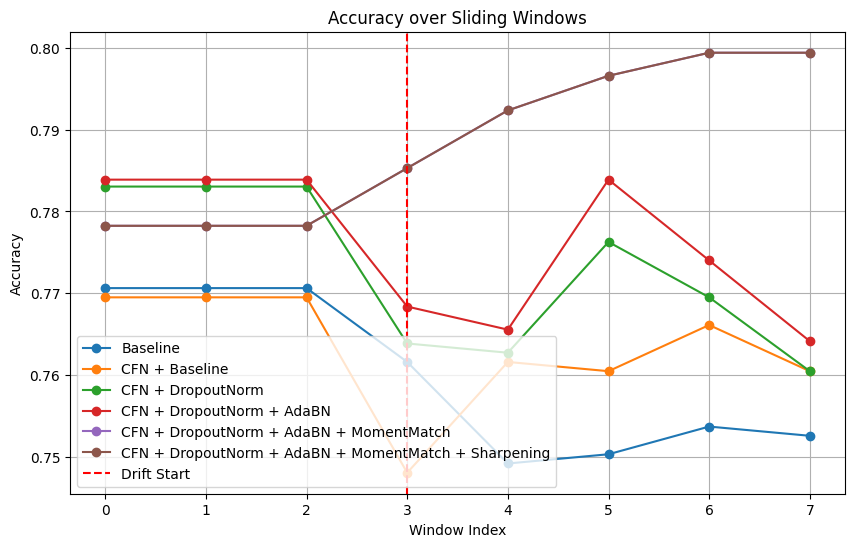

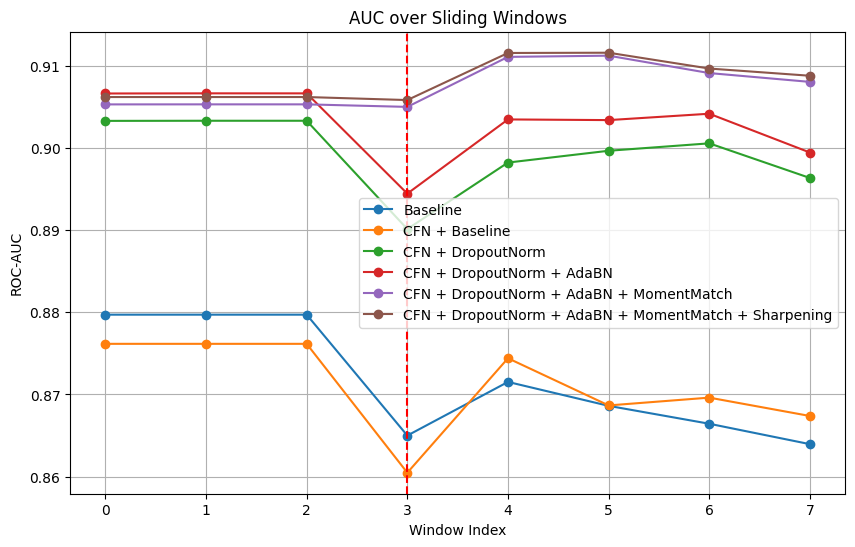

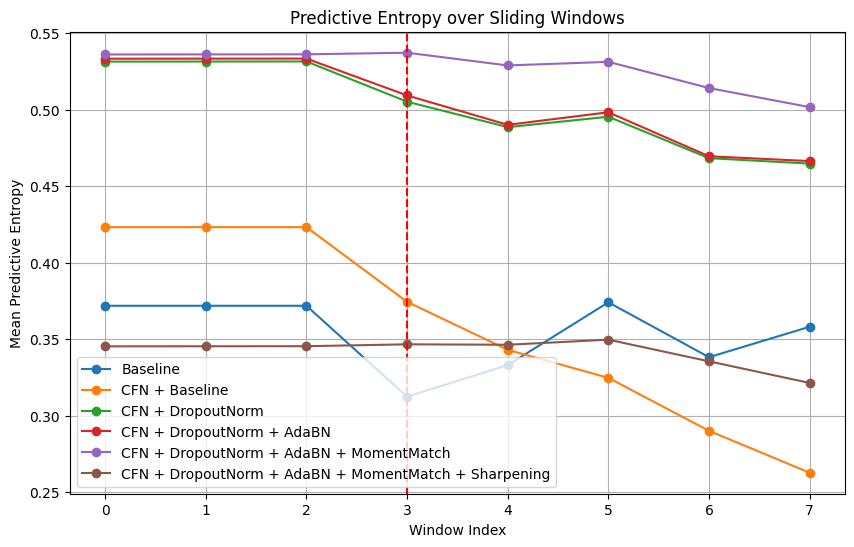

In [28]:
plt.figure(figsize=(10,6))
plt.plot(hist['baseline']['acc'], marker='o', label='Baseline')
plt.plot(hist['cfn']['acc'], marker='o', label='CFN + Baseline')
plt.plot(hist['dropout']['acc'], marker='o', label='CFN + DropoutNorm')
plt.plot(hist['adabn']['acc'], marker='o', label='CFN + DropoutNorm + AdaBN')
plt.plot(hist['moment']['acc'], marker='o', label='CFN + DropoutNorm + AdaBN + MomentMatch')
plt.plot(hist['sharpened']['acc'], marker='o', label='CFN + DropoutNorm + AdaBN + MomentMatch + Sharpening')
plt.axvline(drift_window, color='red', linestyle='--', label='Drift Start')
plt.xlabel('Window Index')
plt.ylabel('Accuracy')
plt.title('Accuracy over Sliding Windows')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(hist['baseline']['auc'], marker='o', label='Baseline')
plt.plot(hist['cfn']['auc'], marker='o', label='CFN + Baseline')
plt.plot(hist['dropout']['auc'], marker='o', label='CFN + DropoutNorm')
plt.plot(hist['adabn']['auc'], marker='o', label='CFN + DropoutNorm + AdaBN')
plt.plot(hist['moment']['auc'], marker='o', label='CFN + DropoutNorm + AdaBN + MomentMatch')
plt.plot(hist['sharpened']['auc'], marker='o', label='CFN + DropoutNorm + AdaBN + MomentMatch + Sharpening')
plt.axvline(drift_window, color='red', linestyle='--')
plt.xlabel('Window Index')
plt.ylabel('ROC-AUC')
plt.title('AUC over Sliding Windows')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(hist['baseline']['ent'], marker='o', label='Baseline')
plt.plot(hist['cfn']['ent'], marker='o', label='CFN + Baseline')
plt.plot(hist['dropout']['ent'], marker='o', label='CFN + DropoutNorm')
plt.plot(hist['adabn']['ent'], marker='o', label='CFN + DropoutNorm + AdaBN')
plt.plot(hist['moment']['ent'], marker='o', label='CFN + DropoutNorm + AdaBN + MomentMatch')
plt.plot(hist['sharpened']['ent'], marker='o', label='CFN + DropoutNorm + AdaBN + MomentMatch + Sharpening')
plt.axvline(drift_window, color='red', linestyle='--')
plt.xlabel('Window Index')
plt.ylabel('Mean Predictive Entropy')
plt.title('Predictive Entropy over Sliding Windows')
plt.legend()
plt.grid(True)
plt.show()

## Takeaways

This pipeline demonstrates a practical, end-to-end approach for maintaining student outcome prediction performance under realistic curriculum and economic shifts. Controlled experiments show that simple defenses, such as clustered feature noise or utilizing Dropout and BatchNorm architecture, can improve robustness. However, the largest gains come from adaptation: recalibrating BatchNorm with unlabeled data (AdaBN) and aligning feature moments (moment-matching), followed by lightweight output sharpening.

The sliding-window study makes two operational lessons clear: (1) evaluate every method on the same held-out eval split to avoid biased comparisons, and (2) prefer cheap, online fixes like AdaBN, moment-matching as first responses and reserve full retraining for sustained or large drifts. Practically, implementing safeguards makes adaptation reliable in production while monitoring drift metrics to trigger more costly interventions.